## Import necessary libraries

In [1]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.exceptions import DataConversionWarning

import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)

In [7]:
data = pd.read_csv('data_26.csv')

### Data Format
Instead of picking up dataset directly from Kaggle, I preferred to get the data from the website of [US Bureau of Transportation Statistics](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236) for the month of February 2020.
After carefully analyzing each data points, I decided to manually pick 9 variable to predict if there will be a delay in the flight.
- __MONTH__ - Month
- __DAY_OF_MONTH__ - Day of Month
- __DAY_OF_WEEK__ - Day of Week
- __OP_UNIQUE_CARRIER__ - Unique Carrier Code
- __ORIGIN__ - Origin airport location
- __DEST__ - Destination airport location
- __DEP_TIME__ - Actual Departure Time (local time: hhmm)
- __DEP_DEL15__ - Departure Delay Indicator, 15 Minutes or More (1=Yes, 0=No) [TARGET VARIABLE]
- __DISTANCE__ - Distance between airports (miles)

In [10]:
data.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DISTANCE,Unnamed: 9
0,2,1,6,MQ,CLT,LYH,1430.0,0.0,175.0,NaN
1,2,8,6,MQ,CLT,LYH,1442.0,0.0,175.0,NaN
2,2,13,4,MQ,DFW,SHV,2247.0,0.0,190.0,NaN
3,2,14,5,MQ,DFW,SHV,2230.0,0.0,190.0,NaN
4,2,15,6,MQ,DFW,SHV,2246.0,0.0,190.0,NaN


## Data Preprocessing

In [11]:
data = data.drop(['Unnamed: 9'], axis=1)

In [12]:
data['DEP_DEL15'].value_counts()

0.0    487135
1.0     82182
Name: DEP_DEL15, dtype: int64

In [13]:
# Split the data into positive and negative
positive_rows = data.DEP_DEL15 == 1.0
data_pos = data.loc[positive_rows]
data_neg = data.loc[~positive_rows]

# Merge the balanced data
data = pd.concat([data_pos, data_neg.sample(n = len(data_pos))], axis = 0)
print(data.head())

# Shuffle the order of data
data = data.sample(n = len(data)).reset_index(drop = True)
print(data.head())

    MONTH  DAY_OF_MONTH  DAY_OF_WEEK OP_UNIQUE_CARRIER ORIGIN DEST  DEP_TIME  \
39      2            23            7                MQ    BTR  DFW     802.0   
48      2             3            1                MQ    EWR  ORD     623.0   
74      2             5            3                MQ    DFW  BTR    2123.0   
76      2             7            5                MQ    DFW  BTR    2225.0   
85      2            18            2                MQ    DFW  BTR    2215.0   

    DEP_DEL15  DISTANCE  
39        1.0     383.0  
48        1.0     719.0  
74        1.0     383.0  
76        1.0     383.0  
85        1.0     383.0  
   MONTH  DAY_OF_MONTH  DAY_OF_WEEK OP_UNIQUE_CARRIER ORIGIN DEST  DEP_TIME  \
0      2             4            2                F9    RSW  MSP    1110.0   
1      2            29            6                YV    TUS  IAH    1444.0   
2      2            27            4                DL    ATL  BWI    1058.0   
3      2            13            4            

In [14]:
data.isna().sum()

MONTH                  0
DAY_OF_MONTH           0
DAY_OF_WEEK            0
OP_UNIQUE_CARRIER      0
ORIGIN                 0
DEST                   0
DEP_TIME             841
DEP_DEL15            843
DISTANCE               0
dtype: int64

In [15]:
data = data.dropna(axis=0)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163521 entries, 0 to 164363
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   MONTH              163521 non-null  int64  
 1   DAY_OF_MONTH       163521 non-null  int64  
 2   DAY_OF_WEEK        163521 non-null  int64  
 3   OP_UNIQUE_CARRIER  163521 non-null  object 
 4   ORIGIN             163521 non-null  object 
 5   DEST               163521 non-null  object 
 6   DEP_TIME           163521 non-null  float64
 7   DEP_DEL15          163521 non-null  float64
 8   DISTANCE           163521 non-null  float64
dtypes: float64(3), int64(3), object(3)
memory usage: 12.5+ MB


In [17]:
data['DEP_DEL15'] = data['DEP_DEL15'].astype(int)
data.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DISTANCE
0,2,4,2,F9,RSW,MSP,1110.0,0,1416.0
1,2,29,6,YV,TUS,IAH,1444.0,0,936.0
2,2,27,4,DL,ATL,BWI,1058.0,0,577.0
3,2,13,4,F9,PHX,SAN,1000.0,1,304.0
4,2,28,5,YV,DFW,OKC,1914.0,1,175.0


In [62]:
data.shape

(163595, 9)

## Exploratory Data Analysis

In [63]:
data.describe()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME,DEP_DEL15,DISTANCE
count,163595.0,163595.000000,163595.000000,163595.000000,163595.000000,163595.000000
mean,2.0,14.811914,4.023008,1416.055063,0.502350,793.641633
std,0.0,8.172280,1.919351,498.612640,0.499996,575.418990
min,2.0,1.000000,1.000000,1.000000,0.000000,31.000000
25%,2.0,7.000000,2.000000,1026.000000,0.000000,370.000000
50%,2.0,14.000000,4.000000,1436.000000,1.000000,646.000000
75%,2.0,22.000000,6.000000,1826.000000,1.000000,1034.000000
max,2.0,29.000000,7.000000,2400.000000,1.000000,5095.000000


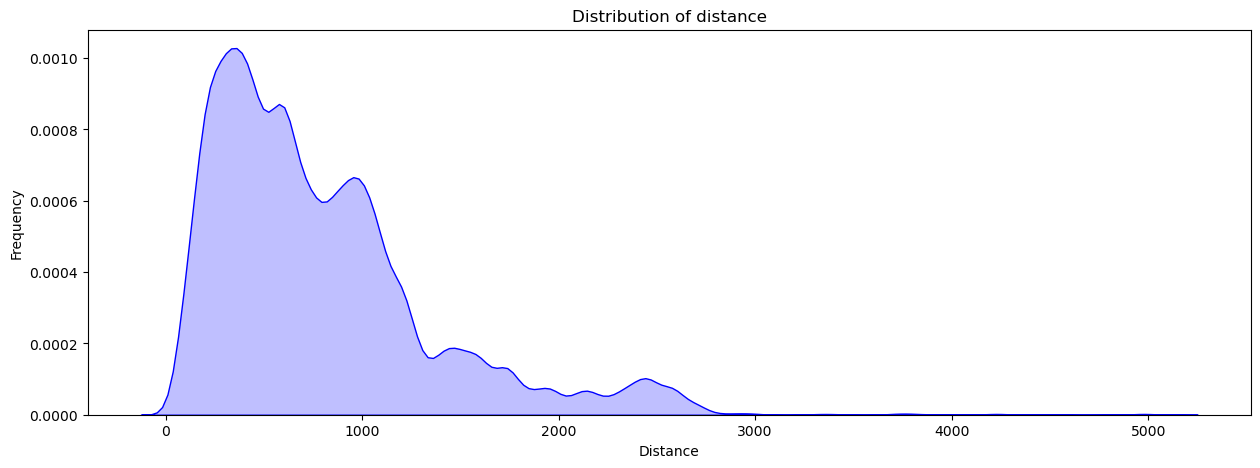

In [64]:
plt.figure(figsize=(15,5))
sns.distplot(data['DISTANCE'], hist=False, color="b", kde_kws={"shade": True})
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.title("Distribution of distance")
plt.show()

In [65]:
print(f"Average distance if there is a delay {data[data['DEP_DEL15'] == 1]['DISTANCE'].values.mean()} miles")
print(f"Average distance if there is no delay {data[data['DEP_DEL15'] == 0]['DISTANCE'].values.mean()} miles")

Average distance if there is a delay 786.1071280815751 miles
Average distance if there is no delay 801.2473069411519 miles


### Count of carriers in the dataset

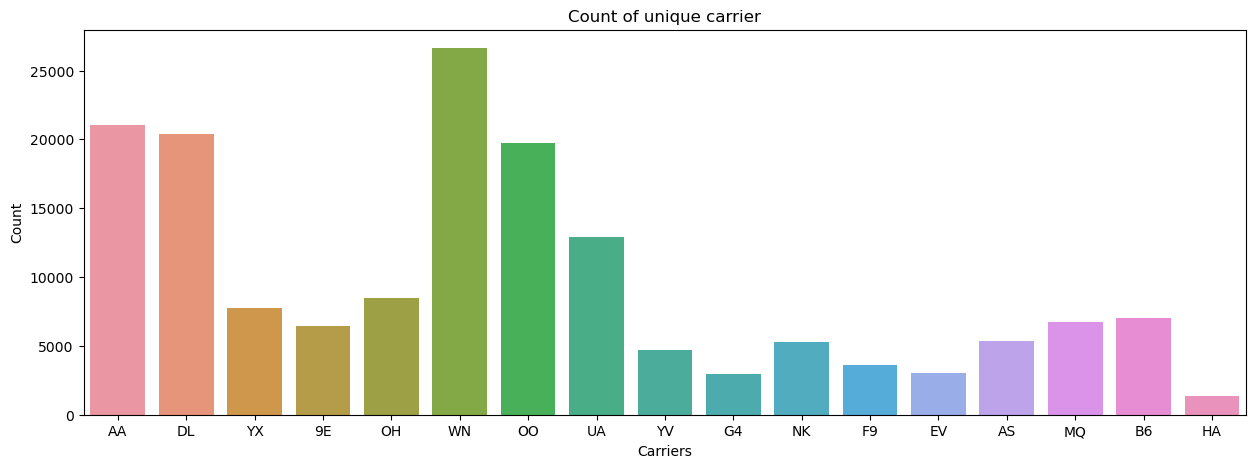

In [66]:
plt.figure(figsize=(15,5))
sns.countplot(x=data['OP_UNIQUE_CARRIER'], data=data)
plt.xlabel("Carriers")
plt.ylabel("Count")
plt.title("Count of unique carrier")
plt.show()

### Count of origin and destination airport

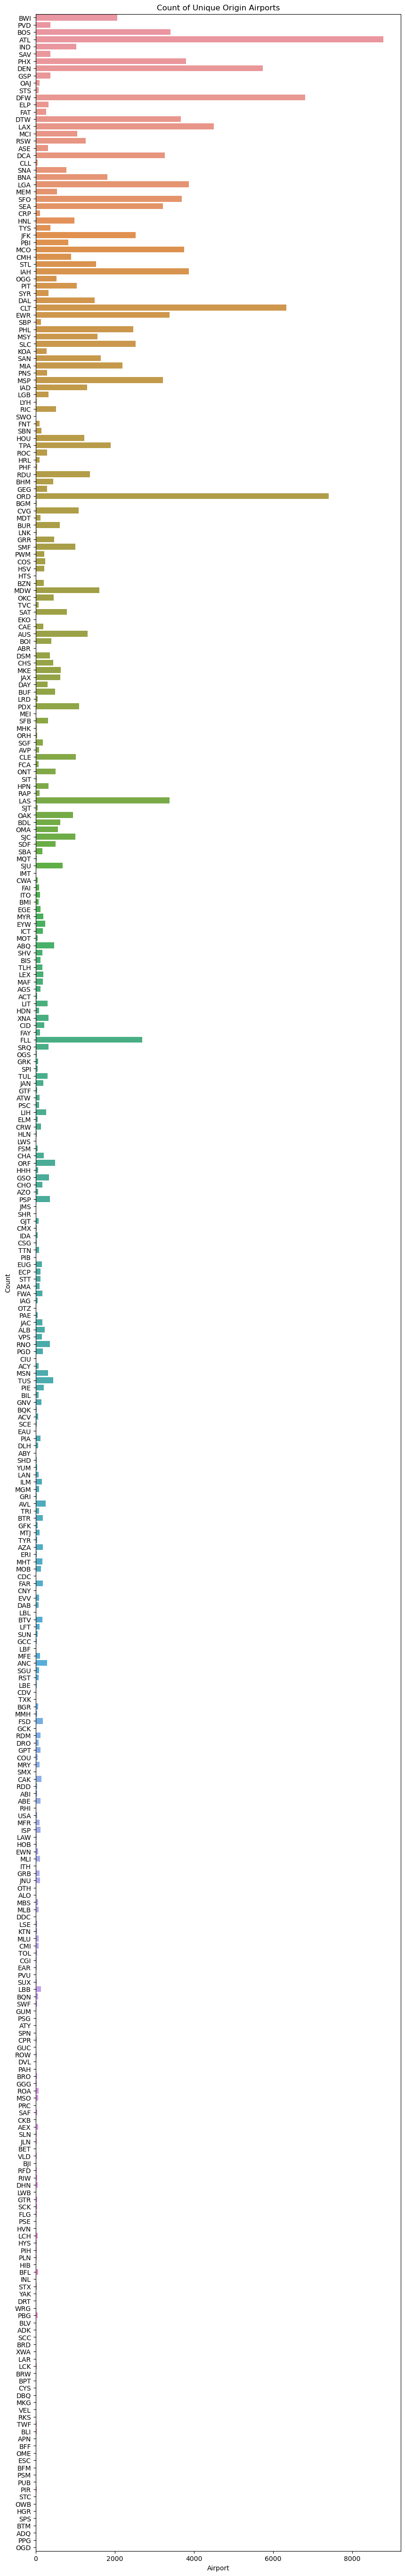

In [67]:
plt.figure(figsize=(10,70))
sns.countplot(y=data['ORIGIN'], data=data, orient="h")
plt.xlabel("Airport")
plt.ylabel("Count")
plt.title("Count of Unique Origin Airports")
plt.show()

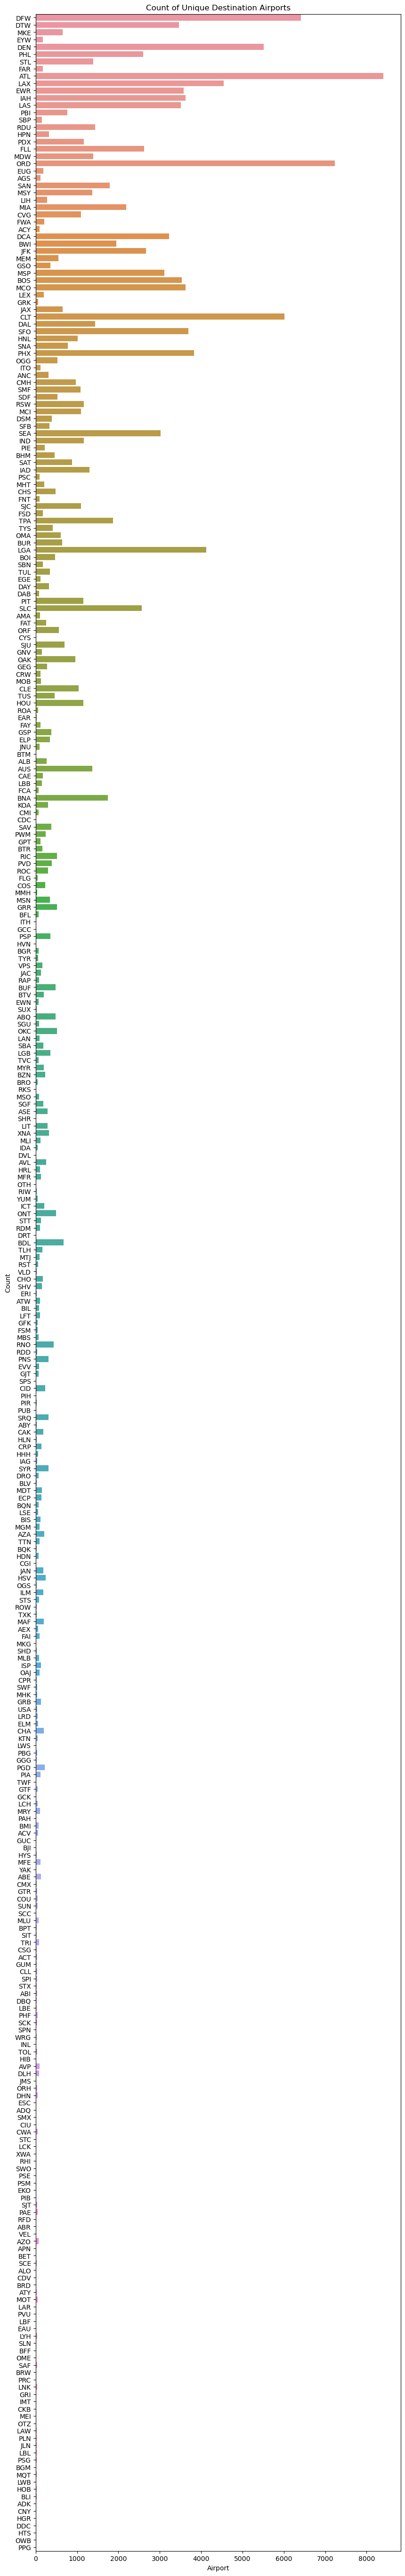

In [68]:
plt.figure(figsize=(10,70))
sns.countplot(y=data['DEST'], data=data, orient="h")
plt.xlabel("Airport")
plt.ylabel("Count")
plt.title("Count of Unique Destination Airports")
plt.show()

## Modelling


In [19]:
data = data.rename(columns={'DEP_DEL15':'TARGET'})

__Encoding the categorical variable__

In [20]:
def label_encoding(categories):
    #To perform mapping of categorical features
    categories = list(set(list(categories.values)))
    mapping = {}
    for idx in range(len(categories)):
        mapping[categories[idx]] = idx
    return mapping

In [21]:
data['OP_UNIQUE_CARRIER'] = data['OP_UNIQUE_CARRIER'].map(label_encoding(data['OP_UNIQUE_CARRIER']))

In [22]:
data['ORIGIN'] = data['ORIGIN'].map(label_encoding(data['ORIGIN']))

In [23]:
data['DEST'] = data['DEST'].map(label_encoding(data['DEST']))

In [24]:
data.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,TARGET,DISTANCE
0,2,4,2,8,184,47,1110.0,0,1416.0
1,2,29,6,11,1,324,1444.0,0,936.0
2,2,27,4,5,103,318,1058.0,0,577.0
3,2,13,4,8,277,58,1000.0,1,304.0
4,2,28,5,11,132,148,1914.0,1,175.0


In [25]:
data['TARGET'].value_counts()

1    82182
0    81339
Name: TARGET, dtype: int64

In [26]:
X = data.drop(['MONTH','TARGET'], axis=1)
y = data[['TARGET']].values
X.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,DISTANCE
0,4,2,8,184,47,1110.0,1416.0
1,29,6,11,1,324,1444.0,936.0
2,27,4,5,103,318,1058.0,577.0
3,13,4,8,277,58,1000.0,304.0
4,28,5,11,132,148,1914.0,175.0


In [29]:
# Splitting Train-set and Test-set
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=41)

# Splitting Train-set and Validation-set
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=41)

### Choosing the evaluation metric

In [30]:
# Formula to get accuracy
def get_accuracy(y_true, y_preds):
    # Getting score of confusion matrix
    true_negative, false_positive, false_negative, true_positive = confusion_matrix(y_true, y_preds).ravel()
    # Calculating accuracy
    accuracy = (true_positive + true_negative)/(true_negative + false_positive + false_negative + true_positive)
    return accuracy

### Creating some baseline models

__Logistic Regression__

In [31]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0).fit(X_train, y_train)

C:\Users\sarit\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


__CatboostClassifier__

In [32]:
# Initialize CatBoostClassifier
catboost = CatBoostClassifier(random_state=0)
catboost.fit(X_train, y_train, verbose=False)

__Naive Bayes__

In [33]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

__Random Forest Classifier__

In [34]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

__KNN Classifier__

In [35]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
#accuracy score of the training data
X_train_predict=knn.predict(X_train)
train_acc=get_accuracy(X_train_predict,y_train)
print("accuracy of trained data:",train_acc)

#accuracy score of testing data
X_test_predict=knn.predict(X_test)
test_acc=get_accuracy(X_test_predict,y_test)
print("accuracy of tested data:",test_acc)


input_data=(30,2,5,56,206,2240,100)
#input_data_as_numpy
reshaped=np.asarray(input_data)

reshaped=reshaped.reshape(1,-1)


print(reshaped)
res=knn.predict(reshaped)

if(res[0]==0):
    print("flight won't be delayed")
else:
    print("flight will be delayed")


accuracy of trained data: 0.87426614481409
accuracy of tested data: 0.725546552514906
[[  30    2    5   56  206 2240  100]]
flight won't be delayed


C:\Users\sarit\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


### Evaluation of accuracy on validation dataset

In [36]:
models = [lr, catboost, gnb, rf, knn]
acc = []
for model in models:
    preds_val = model.predict(X_val)
    accuracy = get_accuracy(y_val, preds_val)
    acc.append(accuracy)

NameError: name 'X_val' is not defined

In [46]:
model_name = ['Logistic Regression', 'Catboost', 'Naive Bayes', 'Random Forest', 'KNN']
accuracy = dict(zip(model_name, acc))

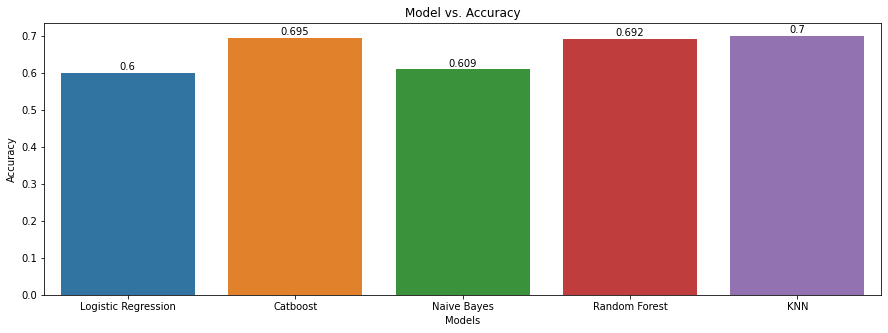

In [35]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x = list(accuracy.keys()), y = list(accuracy.values()))
for p, value in zip(ax.patches, list(accuracy.values())):
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 0.008
    ax.text(_x, _y, round(value, 3), ha="center") 
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model vs. Accuracy")
plt.show()

In [97]:
import pickle


In [98]:
filename='trained_model.sav'
pickle.dump(knn,open(filename,'wb'))


In [99]:
#loading model
loaded_model=pickle.load(open('trained_model.sav','rb'))

In [100]:
input_data=(30,2,5,56,206,2240,100)
#input_data_as_numpy
reshaped=np.asarray(input_data)

reshaped=reshaped.reshape(1,-1)



res=loaded_model.predict(reshaped)

if(res[0]==0):
    print("flight won't be delayed")
else:
    print("flight will be delayed")

flight won't be delayed


C:\Users\sarit\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
